In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

sys.path.append('../../../src')
from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity
from common.default import PASSING_DEFAULT
from display.display import display
from individual_activity.individual_activity import IndividualActivity

import warnings
warnings.simplefilter("ignore")

In [2]:
device_idx = 1
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:1'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'},
]

In [4]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|██████████| 23/23 [00:03<00:00,  6.55it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|██████████| 41/41 [00:04<00:00, 10.08it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|██████████| 9/9 [00:01<00:00,  4.96it/s]


# keypointsを抽出

In [7]:
min_len = 30
keypoitns_dict_all = {}
for label, ind in tqdm(individuals.items()):
    data = ind.get_keypoints_dict(window=3, is_std=True)
    if len(data) >= min_len:
        keypoitns_dict_all[label] = data

100%|██████████| 1341/1341 [00:48<00:00, 27.55it/s]


# オートエンコーダで特徴量抽出

In [8]:
from individual_activity.autoencoder import Encoder, Decoder, RecurrentAutoencoder
model_path = f'{common.root}/model/pass_model_autoencoder_32.pth'
model = torch.load(model_path)
model.to(device)
model.eval()

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(34, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
    (rnn3): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (rnn3): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=34, bias=True)
  )
)

In [9]:
SEQ_LEN = 30

In [10]:
features_dict = {}
with torch.no_grad():
    for label , kps_dict in tqdm(keypoitns_dict_all.items()):
        features = {}
        for frame_num in list(kps_dict.keys())[:len(kps_dict) - SEQ_LEN + 1]:
            x = []
            for i in range(SEQ_LEN):
                x.append(kps_dict[frame_num + i])

            if np.any(np.isnan(x)):
                continue

            x = tensor(x).float().to(device)
            _, z = model(x)
            z = z.cpu().numpy().flatten()
            
            features[frame_num] = z

        features_dict[label] = features

100%|██████████| 866/866 [04:01<00:00,  3.59it/s]


In [11]:
features_all = []
for features in features_dict.values():
    features_all += list(features.values())

n_components = 3
pca = PCA(n_components=n_components)
pca.fit(features_all)

PCA(n_components=3)

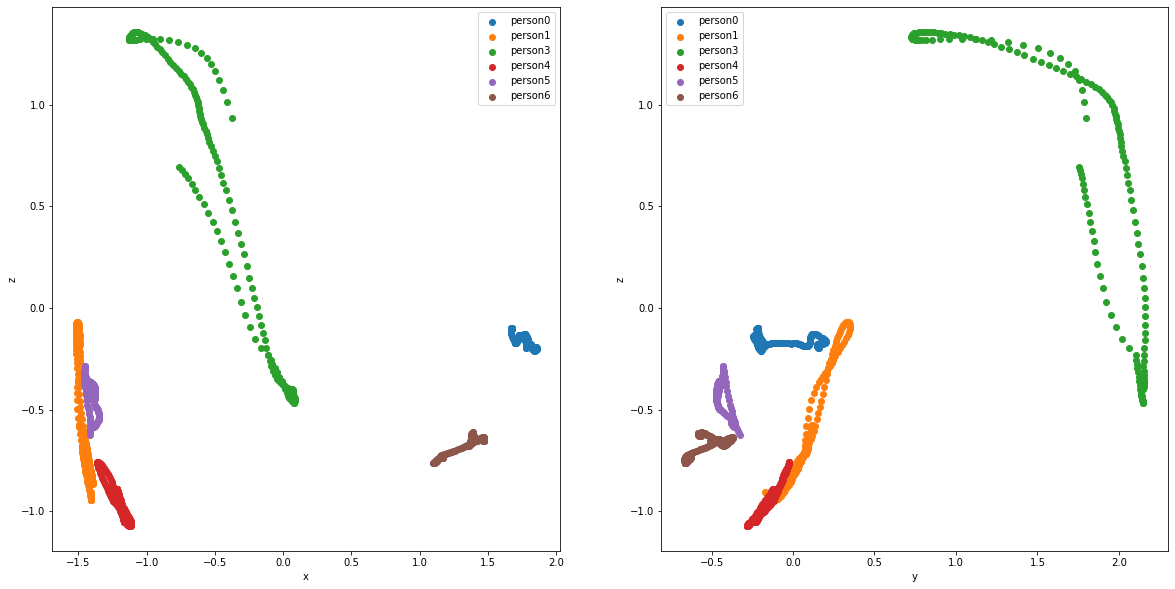

In [12]:
ROOM_NUM = '09'
DATE = '20210706'
FILE_NUM = '05'

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for key, features in features_dict.items():
    if key.split('_')[:2] != [ROOM_NUM, FILE_NUM]:
        continue
    if len(features) == 0:
        continue
    
    features = list(features.values())
    features = pca.transform(features)
    x = features.T[0]
    y = features.T[1]
    z = features.T[2]
    ax1.scatter(x, z, label=f"person{key.split('_')[-1]}")
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.legend()
    ax2.scatter(y, z, label=f"person{key.split('_')[-1]}")
    ax2.set_xlabel('y')
    ax2.set_ylabel('z')
    ax2.legend()

## 受け渡し中かどうかでプロット

In [13]:
dirs = []
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    dirs += glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
    if dirs[-1].endswith('make_csv.csv'):
        dirs = sorted(dirs)[:-1]  # delete make_csv.csv

pass_lst = []
not_pass_lst = []
for path in dirs:
    csv_path = f'{path}/csv/data.csv'
    print(csv_path)
    csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

    for row in tqdm(csv_data):
        frame_num = row[0]
        label1 = f'{ROOM_NUM}_{FILE_NUM}_{row[1]}'
        label2 = f'{ROOM_NUM}_{FILE_NUM}_{row[2]}'
        is_pass = row[3]

        if label1 not in features_dict or label2 not in features_dict:
            continue
        f1 = features_dict[label1]
        f2 = features_dict[label2]

        if frame_num not in f1 or frame_num not in f2:
            continue
        f1 = f1[frame_num]
        f2 = f2[frame_num]
        f1 = pca.transform([f1])
        f2 = pca.transform([f2])
        
        # if is_pass == 1:
        #     pass_lst.append(f1)
        #     pass_lst.append(f2)
        # else:
        #     not_pass_lst.append(f1)
        #     not_pass_lst.append(f2)
            
        f = f1 - f2
        if is_pass == 1:
            pass_lst.append(f)
        else:
            not_pass_lst.append(f)
            
pass_lst = np.array(pass_lst)
not_pass_lst = np.array(not_pass_lst)

/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/01/csv/data.csv


100%|██████████| 5442/5442 [00:00<00:00, 44776.59it/s]

/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/02/csv/data.csv



100%|██████████| 15652/15652 [00:00<00:00, 101246.19it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/03/csv/data.csv


100%|██████████| 4467/4467 [00:00<00:00, 86803.63it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/04/csv/data.csv


100%|██████████| 1862/1862 [00:00<00:00, 33271.11it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/05/csv/data.csv


100%|██████████| 3871/3871 [00:00<00:00, 32528.84it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/06/csv/data.csv


100%|██████████| 8988/8988 [00:00<00:00, 40373.69it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/07/csv/data.csv


100%|██████████| 6588/6588 [00:00<00:00, 38047.08it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/08/csv/data.csv


100%|██████████| 10843/10843 [00:00<00:00, 52322.58it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/09/csv/data.csv


100%|██████████| 21966/21966 [00:00<00:00, 89660.41it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/10/csv/data.csv


100%|██████████| 43537/43537 [00:00<00:00, 295320.69it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/11/csv/data.csv


100%|██████████| 17141/17141 [00:00<00:00, 72960.89it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/12/csv/data.csv


100%|██████████| 7030/7030 [00:00<00:00, 39031.71it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/13/csv/data.csv


100%|██████████| 13649/13649 [00:00<00:00, 84899.10it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/14/csv/data.csv


100%|██████████| 14344/14344 [00:00<00:00, 72716.34it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/15/csv/data.csv


100%|██████████| 22431/22431 [00:00<00:00, 212764.72it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/16/csv/data.csv


100%|██████████| 6414/6414 [00:00<00:00, 50690.99it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/17/csv/data.csv


100%|██████████| 3608/3608 [00:00<00:00, 20174.92it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/18/csv/data.csv


100%|██████████| 12254/12254 [00:00<00:00, 96394.92it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/19/csv/data.csv


100%|██████████| 3555/3555 [00:00<00:00, 35974.94it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/20/csv/data.csv


100%|██████████| 5983/5983 [00:00<00:00, 69565.94it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/21/csv/data.csv


100%|██████████| 4427/4427 [00:00<00:00, 24238.61it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/22/csv/data.csv


100%|██████████| 4030/4030 [00:00<00:00, 50859.17it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//02/20210903/passing/23/csv/data.csv


100%|██████████| 6890/6890 [00:00<00:00, 48619.10it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/01/csv/data.csv


100%|██████████| 4667/4667 [00:00<00:00, 29880.29it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/02/csv/data.csv


100%|██████████| 6920/6920 [00:00<00:00, 33362.55it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/03/csv/data.csv


100%|██████████| 14624/14624 [00:00<00:00, 60272.19it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/04/csv/data.csv


100%|██████████| 5831/5831 [00:00<00:00, 29847.18it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/05/csv/data.csv


100%|██████████| 4657/4657 [00:00<00:00, 79639.22it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/06/csv/data.csv


100%|██████████| 2623/2623 [00:00<00:00, 19745.57it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/07/csv/data.csv


100%|██████████| 3148/3148 [00:00<00:00, 17463.55it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/08/csv/data.csv


100%|██████████| 6407/6407 [00:00<00:00, 129146.37it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/09/csv/data.csv


100%|██████████| 3616/3616 [00:00<00:00, 34177.95it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/10/csv/data.csv


100%|██████████| 4754/4754 [00:00<00:00, 44121.26it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/11/csv/data.csv


100%|██████████| 5972/5972 [00:00<00:00, 62400.37it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/12/csv/data.csv


100%|██████████| 6042/6042 [00:00<00:00, 29853.08it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/13/csv/data.csv


100%|██████████| 5968/5968 [00:00<00:00, 27399.71it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/14/csv/data.csv


100%|██████████| 6793/6793 [00:00<00:00, 41429.52it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/15/csv/data.csv


100%|██████████| 3544/3544 [00:00<00:00, 24060.01it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/16/csv/data.csv


100%|██████████| 3764/3764 [00:00<00:00, 25265.76it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/17/csv/data.csv


100%|██████████| 1777/1777 [00:00<00:00, 18271.82it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/18/csv/data.csv


100%|██████████| 2515/2515 [00:00<00:00, 20199.06it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/19/csv/data.csv


100%|██████████| 5623/5623 [00:00<00:00, 36667.27it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/20/csv/data.csv


100%|██████████| 2513/2513 [00:00<00:00, 19713.56it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/21/csv/data.csv


100%|██████████| 3262/3262 [00:00<00:00, 25164.42it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/22/csv/data.csv


100%|██████████| 3539/3539 [00:00<00:00, 18415.68it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/23/csv/data.csv


100%|██████████| 2532/2532 [00:00<00:00, 18760.86it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/24/csv/data.csv


100%|██████████| 9502/9502 [00:00<00:00, 45337.12it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/25/csv/data.csv


100%|██████████| 6071/6071 [00:00<00:00, 36713.52it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/26/csv/data.csv


100%|██████████| 4998/4998 [00:00<00:00, 26217.58it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/27/csv/data.csv


100%|██████████| 7655/7655 [00:00<00:00, 34353.94it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/28/csv/data.csv


100%|██████████| 6956/6956 [00:00<00:00, 43868.23it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/29/csv/data.csv


100%|██████████| 4529/4529 [00:00<00:00, 51044.08it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/30/csv/data.csv


100%|██████████| 4089/4089 [00:00<00:00, 50515.92it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/31/csv/data.csv


100%|██████████| 5338/5338 [00:00<00:00, 33653.03it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/32/csv/data.csv


100%|██████████| 4544/4544 [00:00<00:00, 55392.72it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/33/csv/data.csv


100%|██████████| 3031/3031 [00:00<00:00, 41325.14it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/34/csv/data.csv


100%|██████████| 1803/1803 [00:00<00:00, 24911.16it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/35/csv/data.csv


100%|██████████| 5535/5535 [00:00<00:00, 55661.65it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/36/csv/data.csv


100%|██████████| 2243/2243 [00:00<00:00, 26438.65it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/37/csv/data.csv


100%|██████████| 9452/9452 [00:00<00:00, 91907.68it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/38/csv/data.csv


100%|██████████| 1847/1847 [00:00<00:00, 20117.32it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/39/csv/data.csv


100%|██████████| 2980/2980 [00:00<00:00, 37384.18it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/40/csv/data.csv


100%|██████████| 2759/2759 [00:00<00:00, 32052.80it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//08/20210915/passing/41/csv/data.csv


100%|██████████| 1696/1696 [00:00<00:00, 32417.97it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/01/csv/data.csv


100%|██████████| 7646/7646 [00:00<00:00, 42708.57it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/02/csv/data.csv


100%|██████████| 14759/14759 [00:00<00:00, 74648.02it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/03/csv/data.csv


100%|██████████| 36887/36887 [00:00<00:00, 141380.69it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/04/csv/data.csv


100%|██████████| 25303/25303 [00:00<00:00, 102190.27it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/05/csv/data.csv


100%|██████████| 6391/6391 [00:00<00:00, 29273.72it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/06/csv/data.csv


100%|██████████| 7269/7269 [00:00<00:00, 57454.60it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/07/csv/data.csv


100%|██████████| 4126/4126 [00:00<00:00, 24393.84it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/08/csv/data.csv


100%|██████████| 7153/7153 [00:00<00:00, 55908.53it/s]


/tmp/sh076018/mishare/Research Projects/yokoyama/data//09/20210706/passing/09/csv/data.csv


100%|██████████| 3701/3701 [00:00<00:00, 20172.50it/s]


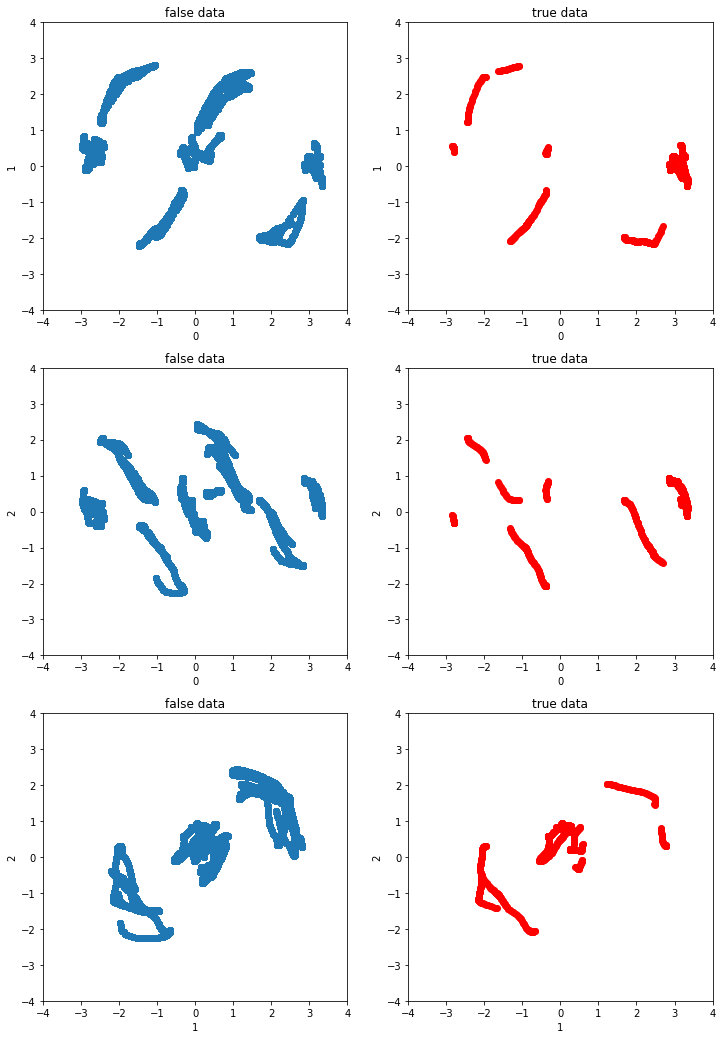

In [14]:
def set_ax(ax, column_i, column_j, title):
    ax.set_title(title)
    ax.set_xlabel(column_i)
    ax.set_ylabel(column_j)
    ax.set_xlim((-4, 4))
    ax.set_ylim((-4, 4))

n = int(n_components * (n_components - 1) / 2)  # 組み合わせ: len(n_components) C 2
fig = plt.figure(figsize=(12, n * 6))
ax_count = 1
for i in range(n_components - 1):
    for j in range(i + 1, n_components):
        ax = fig.add_subplot(n, 2, ax_count * 2 - 1)
        ax.scatter(not_pass_lst.T[i], not_pass_lst.T[j])
        set_ax(ax, i, j, 'false data')

        ax = fig.add_subplot(n, 2, ax_count * 2)
        ax.scatter(pass_lst.T[i], pass_lst.T[j], color='red')
        set_ax(ax, i, j, 'true data')

        ax_count += 1